<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/spectral-imaging
.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
#
#  Copyright 2026 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1)

# Spectral X-ray imaging

This notebook builds up on the polychromatic example, which simulated fluence X-ray images.
Here, we make use of an energy-resolved X-ray detector.

<!-- 

<div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the required packages.
</div> -->

## Aim and objectives of this session

<!-- The aim of this session is to replicate an actual scan.

To achieve this, the main objectives are to:-->

1. Set the flux as the number of photons per pixel.
2. Generate an X-ray image as an energy fluence or using a photon counter detector.
3. Specify the energy resolution of the energy bands in spectral imaging.
4. Restore the normal behaviour (energy fluence or photon counting).

<!-- ![Screenshot of the 3D environment using K3D](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/multi_material-CT_scan/k3d_screenshot-cropped.png?raw=1) -->

In [2]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install libnvidia-gl-575
    !pip install gvxr

## Import packages

In [3]:
import os
import numpy as np

import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm # Look up table

font = {'family' : 'serif',
            'size'   : 15
        }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3.utils import loadSpectrumSpekpy, loadSpectrumXpecgen

Where to save the plots

In [4]:
output_path = "../notebooks/output_data/spectral-imaging"
if not os.path.exists(output_path):
    os.makedirs(output_path)

Create an OpenGL context

In [5]:
gvxr.createOpenGLContext()

Wed Jan  7 16:55:34 2026 ---- Create window (ID: -1)
Wed Jan  7 16:55:34 2026 ---- Request an interactive OpenGL context
Wed Jan  7 16:55:34 2026 ---- Initialise GLFW
Wed Jan  7 16:55:34 2026 ---- Create an OpenGL window with a 4.3 context.
Wed Jan  7 16:55:35 2026 ---- Make the window's context current
Wed Jan  7 16:55:35 2026 ---- Initialise GLEW
Wed Jan  7 16:55:35 2026 ---- OpenGL vendor: NVIDIA Corporation
Wed Jan  7 16:55:35 2026 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Wed Jan  7 16:55:35 2026 ---- OpenGL version: 4.3.0 NVIDIA 580.119.02
Wed Jan  7 16:55:35 2026 ---- Use OpenGL 4.5.
Wed Jan  7 16:55:35 2026 ---- Use OpenGL Compute Shader.
Wed Jan  7 16:55:35 2026 ---- Initialise the X-ray renderer if needed and if possible


Set up the detector

In [6]:
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm")
gvxr.setDetectorUpVector(0, 0, -1)
gvxr.setDetectorNumberOfPixels(512, 320)
gvxr.setDetectorPixelSize(0.5, 0.5, "mm")

Load the sample data

In [7]:
gvxr.removePolygonMeshesFromSceneGraph()

element_set = [6]
for i in range(5):
    element_set.append(element_set[-1] + 5)

angular_step = 360 / (len(element_set))

cmap = matplotlib.cm.get_cmap('hsv')

for i, Z in enumerate(element_set):
    label = gvxr.getElementName(Z)

    print(Z, label)

    gvxr.makeSphere(label, 10, 10, 1.0, "cm")
    gvxr.setElement(label, gvxr.getElementSymbol(Z))

    gvxr.rotateNode(label, i * angular_step, 1, 0, 0)
    gvxr.translateNode(label, 0, 0, 5, "cm")

    rgba = cmap(i / (len(element_set)))
    gvxr.setColour(label, *rgba)

    gvxr.addPolygonMeshAsInnerSurface(label)



6 Carbon
11 Sodium
16 Sulfur
21 Scandium
26 Iron
31 Gallium


/tmp/ipykernel_98737/3948757449.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('hsv')


Create a source

In [8]:
gvxr.setSourcePosition(-40.0,  0.0, 0.0, "cm")
gvxr.usePointSource()
#  For a parallel source, use gvxr.useParallelBeam();

Set its spectrum

```python
loadSpectrumSpekpy(kvp_in_kV, filters=None, th_in_deg=12, max_number_of_energy_bins=None, mAs=None, z=None)
loadSpectrumXpecgen(kvp_in_kV, filters=None, th_in_deg=12, max_number_of_energy_bins=None)
```

In [9]:
kV = 200
filtration = None
max_number_of_energy_bins = 150
number_of_photons_per_pixel_at_SDD = 16000

loadSpectrumXpecgen(kV, filters=filtration, th_in_deg=12, max_number_of_energy_bins=max_number_of_energy_bins);

Wed Jan  7 16:55:41 2026 ---- Initialise the renderer with 32 bits per floating-point numbers in GPU memory
Wed Jan  7 16:55:41 2026 (WW) addEnergyBinToSpectrum is deprecated. It will be removed in a future release. Choose addEnergyBinToSpectrumPerPixelAtSDD or addEnergyBinToSpectrumPerCm2At1m. Note that addEnergyBinToSpectrum and addEnergyBinToSpectrumPerPixelAtSDD are equivalent.


Set the flux. Note
```python
gvxr.setNumberOfPhotons(number_of_photons_per_pixel_at_SDD)
```
will be replaced with
```python
gvxr.setNumberOfPhotonsPerPixelAtSDD(number_of_photons_per_pixel_at_SDD)
```
in the next release of gVXR.

In [10]:
gvxr.setNumberOfPhotons(number_of_photons_per_pixel_at_SDD)
# gvxr.setNumberOfPhotonsPerPixelAtSDD(number_of_photons_per_pixel_at_SDD)

Plot the corresponding spectrum

In [11]:
energy_bins = gvxr.getEnergyBins("keV")
photon_count = np.array(gvxr.getPhotonCountEnergyBins(), dtype=np.single)
photon_count /= photon_count.sum()

Wed Jan  7 16:55:41 2026 (WW) getPhotonCountEnergyBins is deprecated. It will be removed in a future release. Choose getPhotonCountsPerPixelAtSDD or getPhotonCountsPerCm2At1m. Note that getEnergyChannel and getPhotonCountsPerPixelAtSDD are equivalent.


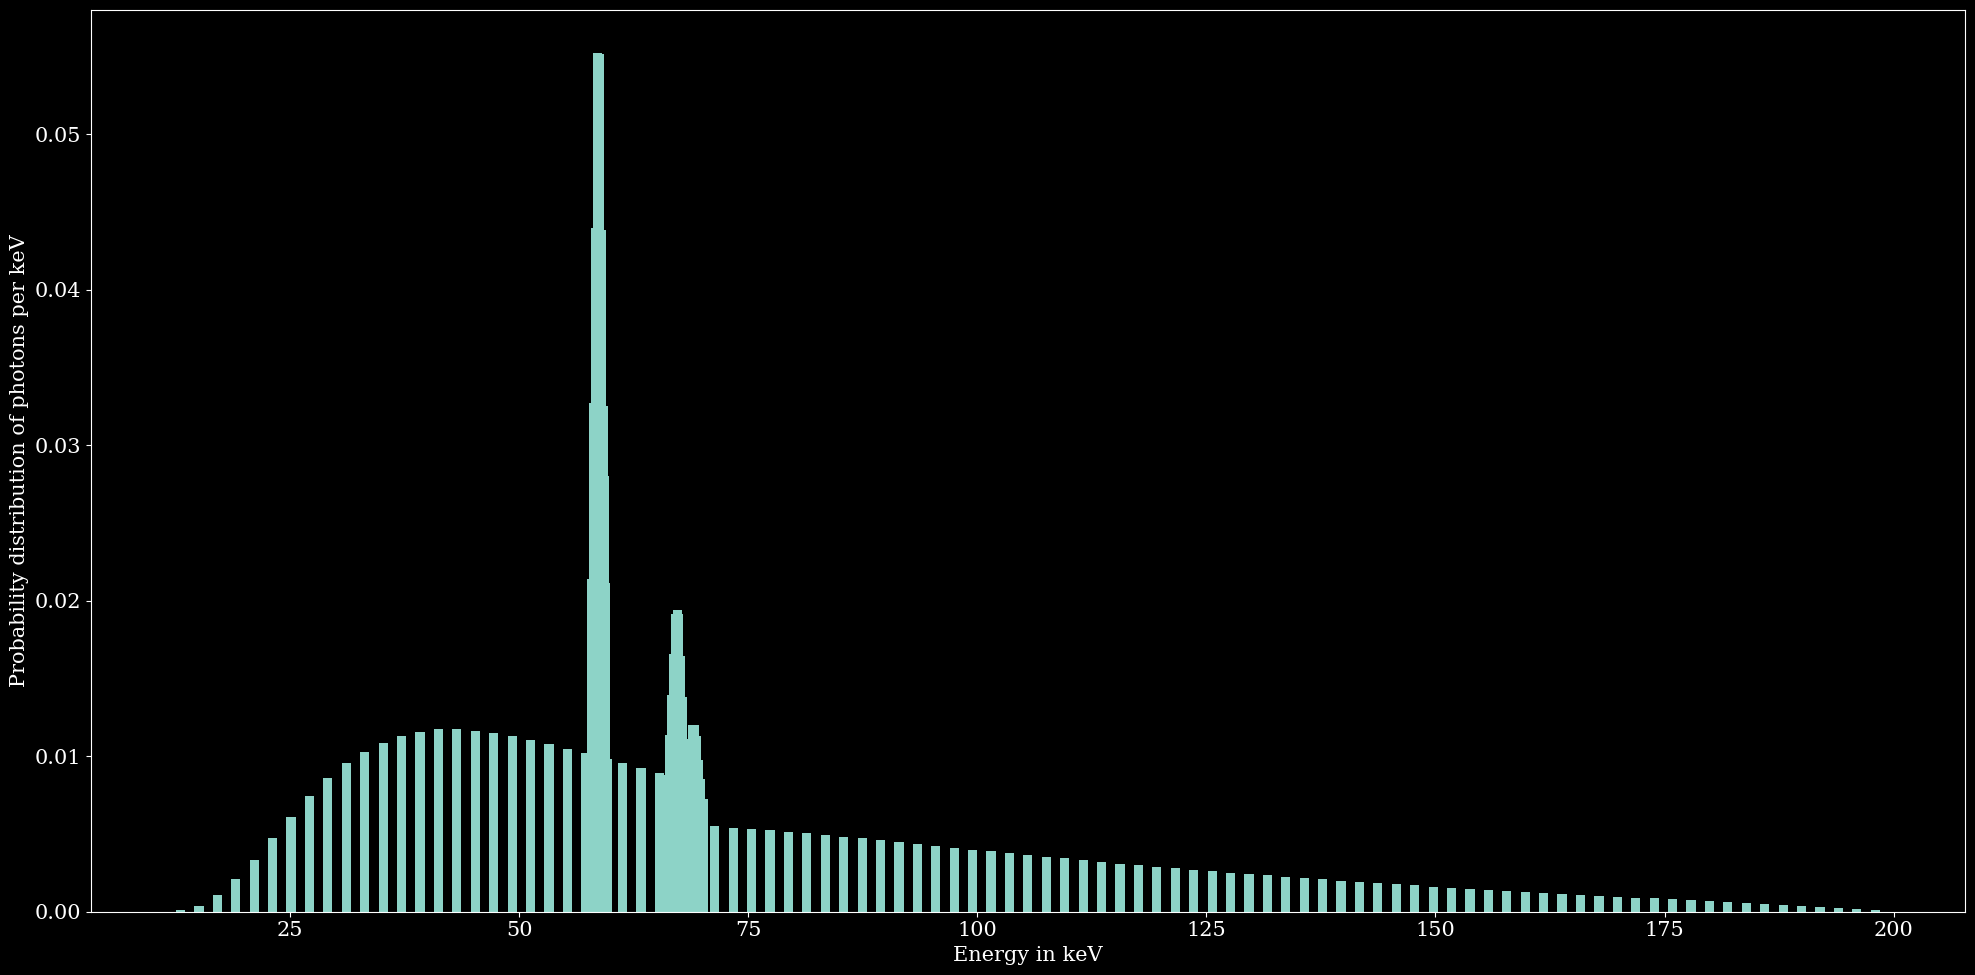

In [12]:
plt.figure(figsize= (20,10))
plt.bar(energy_bins, photon_count, width=1)
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV')
plt.tight_layout()
plt.savefig(output_path + "/spectrum-" + str(kV) + "kV.pdf")
plt.savefig(output_path + "/spectrum-" + str(kV) + "kV.png")

plt.show()

Compute an X-ray image (fluence)

In [13]:
reference_x_ray_image_fluence = np.array(gvxr.computeXRayImage(True), dtype=np.single) / gvxr.getUnitOfEnergy("keV")

Compute an X-ray image (photon counting)

In [14]:
reference_x_ray_image_photon_count = np.array(gvxr.computeXRayImage(False))

Show a screenshot

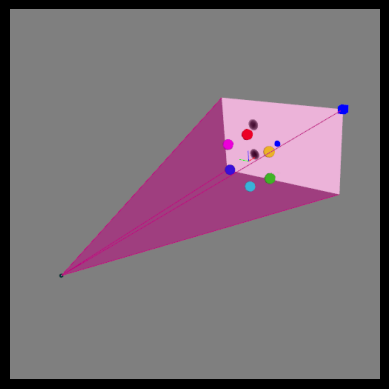

In [15]:
gvxr.displayScene()
gvxr.setZoom(700)
gvxr.setSceneRotationMatrix((0.6400994062423706, 0.3907715976238251, -0.6614910364151001, 0.0, -0.761613667011261, 0.2094639390707016, -0.6132440567016602, 0.0, -0.10107963532209396, 0.8963381052017212, 0.43169528245925903, 0.0, 0.0, 0.0, 0.0, 1.0))

gvxr.displayScene()
screenshot = gvxr.takeScreenshot()

fig, ax = plt.subplots()
ax.imshow(screenshot)
ax.axis("off")
plt.imsave(os.path.join(output_path, "screenshot.png"), np.array(screenshot))
plt.show()

Display the corresponding X-ray images

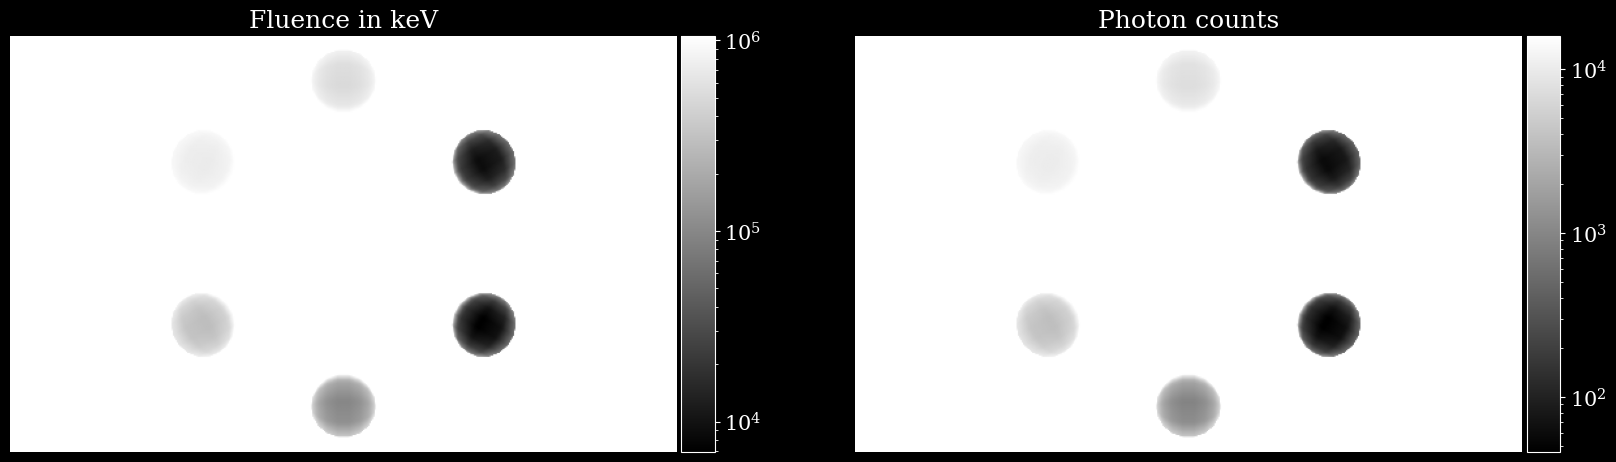

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

axs[0].set_title("Fluence in keV")
img0 = axs[0].imshow(reference_x_ray_image_fluence,
                     cmap="gray",
                     norm=LogNorm(vmin=np.min(reference_x_ray_image_fluence), vmax=np.max(reference_x_ray_image_fluence)))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img0, cax=cax, orientation='vertical')

axs[1].set_title("Photon counts")
img1 = axs[1].imshow(reference_x_ray_image_photon_count,
                     cmap="gray",
                     norm=LogNorm(vmin=np.min(reference_x_ray_image_photon_count), vmax=np.max(reference_x_ray_image_photon_count)))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img1, cax=cax, orientation='vertical')

for ax in axs:
    ax.axis("off")

plt.show()

Specify the energy resolution of each band

In [17]:
gvxr.setPhotonCountingBands(np.min(energy_bins), np.max(energy_bins), "keV", 10)

In [18]:
print("There are", gvxr.getNumberOfPhotonCountingBands(), "energy bands in total")

There are 10 energy bands in total


In [19]:
energy_bands = gvxr.getPhotonCountingBands("keV")
band_width = energy_bands[1] - energy_bands[0]

In [20]:
spectral_images = np.asarray(gvxr.computeSpectralImage(), dtype=np.uint32)

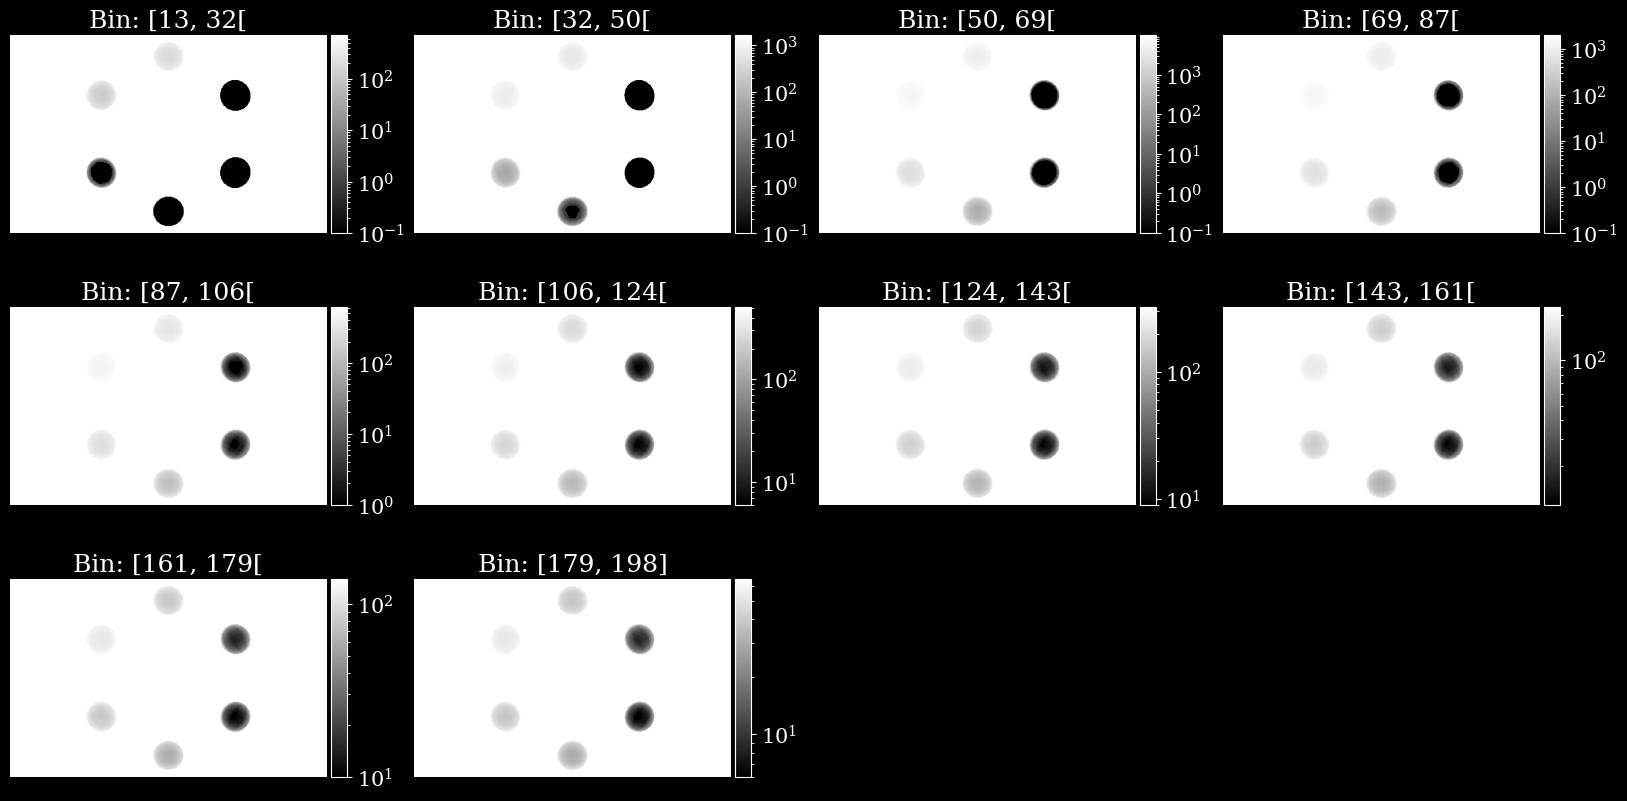

In [21]:
nrows = 3
ncols = gvxr.getNumberOfPhotonCountingBands() // nrows

if gvxr.getNumberOfPhotonCountingBands() % nrows != 0:
    ncols += 1

fig, axs = plt.subplots(nrows, ncols, figsize=(20,10))

for row in range(nrows):
    for col in range(ncols):
        axs[row][col].axis("off")

        i = row * ncols + col

        if i < spectral_images.shape[0]:
            if i < spectral_images.shape[0] - 1:
                axs[row][col].set_title(f"Bin: [{energy_bands[i]:.0f}, {energy_bands[i] + band_width:.0f}[")
            else:
                axs[row][col].set_title(f"Bin: [{energy_bands[i]:.0f}, {energy_bands[i] + band_width:.0f}]")

            vmin = max(0.1, np.min(spectral_images[i]))
            vmax = max(0.1, np.max(spectral_images[i]))

            img = axs[row][col].imshow(spectral_images[i],
                                       cmap="gray",
                                       norm=LogNorm(vmin=vmin, vmax=vmax))
            divider = make_axes_locatable(axs[row][col])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(img, cax=cax, orientation='vertical')

plt.show()

<div class="alert alert-block alert-warning">
<b>Warning:</b> The behaviour of `gvxr.computeXRayImage()` is unspecified after the call of `gvxr
.setPhotonCountingBands()`.
</div>

In [22]:
x_ray_image_photon_count = np.array(gvxr.computeXRayImage(False))

On the plot below, you can see that the brightness/contrast is slightly off compared to the images we first generated.

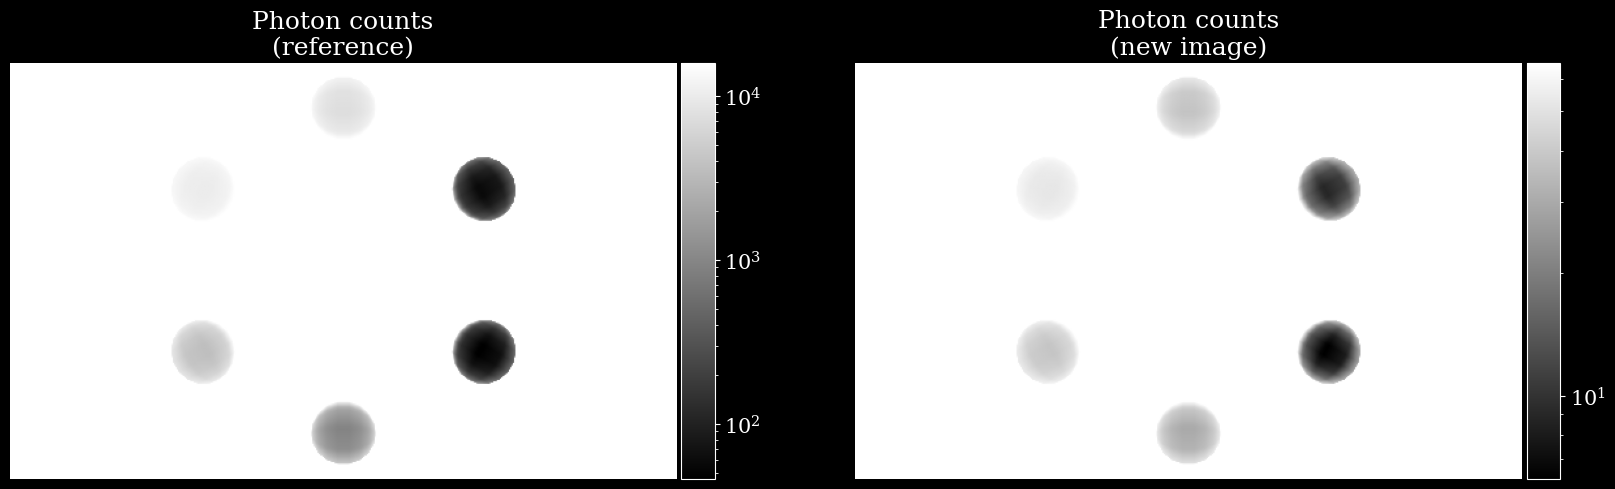

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

axs[0].set_title("Photon counts\n(reference)")
img0 = axs[0].imshow(reference_x_ray_image_photon_count,
                     cmap="gray",
                     norm=LogNorm(vmin=np.min(reference_x_ray_image_photon_count), vmax=np.max(reference_x_ray_image_photon_count)))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img0, cax=cax, orientation='vertical')

axs[1].set_title("Photon counts\n(new image)")
img1 = axs[1].imshow(x_ray_image_photon_count,
                     cmap="gray",
                     norm=LogNorm(vmin=np.min(x_ray_image_photon_count), vmax=np.max(x_ray_image_photon_count)))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img1, cax=cax, orientation='vertical')

for ax in axs:
    ax.axis("off")

plt.show()

<div class="alert alert-block alert-info">
<b>Tip:</b> You must call `gvxr.mergePhotonCountingBands()` to restore the normal behaviour of `gvxr.computeXRayImage()`.
</div>

In [24]:
gvxr.mergePhotonCountingBands()

In [25]:
x_ray_image_fluence = np.array(gvxr.computeXRayImage(True), dtype=np.single) / gvxr.getUnitOfEnergy("keV")
x_ray_image_photon_count = np.array(gvxr.computeXRayImage(False))


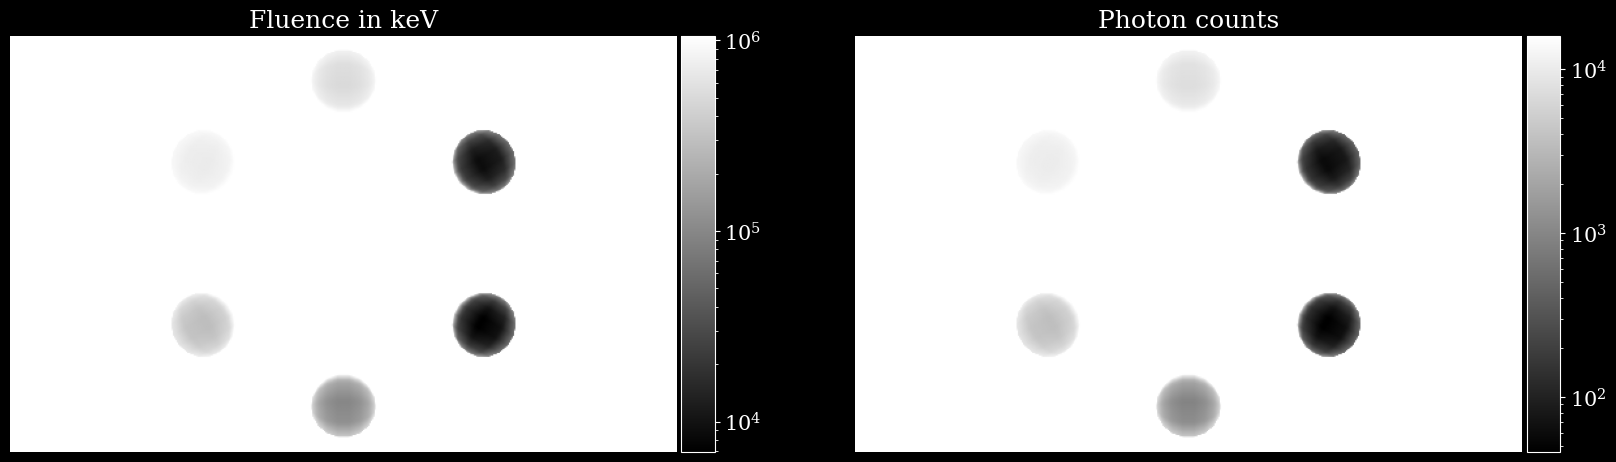

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

axs[0].set_title("Fluence in keV")
img0 = axs[0].imshow(x_ray_image_fluence,
                     cmap="gray",
                     norm=LogNorm(vmin=np.min(x_ray_image_fluence), vmax=np.max(x_ray_image_fluence)))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img0, cax=cax, orientation='vertical')

axs[1].set_title("Photon counts")
img1 = axs[1].imshow(x_ray_image_photon_count,
                     cmap="gray",
                     norm=LogNorm(vmin=np.min(x_ray_image_photon_count), vmax=np.max(x_ray_image_photon_count)))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img1, cax=cax, orientation='vertical')

for ax in axs:
    ax.axis("off")

plt.show()